# BEM 111 HW 4 
## Problem 1 
### Iris Xiang

In [145]:
import pandas as pd
import qrpm_funcs as qf
import numpy as np

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)
multipliers=[-1,1,-1]

lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)

In [146]:
returns = np.exp(difflgs)
weights = np.array([6,-12,7])

In [147]:
import copy 
def first_strategy(returns, weights):
    portfolio = []
    portfolio_value = []
    for i in range(len(returns)):
        portfolio.append(weights*returns[i])
        weights = portfolio[-1]
        portfolio_value.append(sum(weights))
    return portfolio, portfolio_value   

In [148]:
portfolio1, portfolio_value1 = first_strategy(returns, weights)

Text(0.5, 1.0, 'Buy and Hold Strategy Portfolio Value')

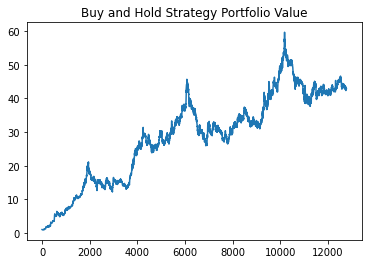

In [149]:
import matplotlib.pyplot as plt
x = np.arange(len(lgdates))
plt.plot(x, portfolio_value1)
plt.title("Buy and Hold Strategy Portfolio Value")

In [153]:
min(portfolio_value1)

0.8947080965648011

We see that for the buy and hold strategy, we never go bankrupt, and the lowest value we reach during the study period is 0.8947. 

In [150]:
def second_strategy(returns, starting_weights,lgdates):
    portfolio = []
    portfolio_values = []
    prev_date = '01'
    dates_bankrupt = []
    weights = copy.deepcopy(starting_weights)
    for date, value in zip(lgdates, returns):
        if date[5:7] != prev_date:
            weights = np.multiply(starting_weights, portfolio_values[-1])
            prev_date = date[5:7]
        portfolio.append(weights*value)
        weights = portfolio[-1]
        portfolio_values.append(sum(weights))
        if portfolio_values[-1] < 0:
            dates_bankrupt.append(date)
    return portfolio, portfolio_values, dates_bankrupt

In [151]:
portfolio2, portfolio_values2, dates_bankrupt = second_strategy(returns, weights,lgdates)


Text(0.5, 1.0, 'Monthly Rebalancing Strategy Portfolio Value')

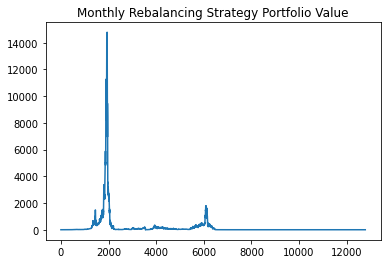

In [152]:
plt.plot(x, portfolio_values2)
plt.title("Monthly Rebalancing Strategy Portfolio Value")

In [154]:
len(dates_bankrupt)

1269

In [155]:
dates_bankrupt[0]

'1985-03-27'

We see that with the monthly rebalancing strategy, we do go bankrupt. The first date that we go bankrupt is in March of 1985. 

## Problem 4

In [158]:
learning_dates,learning_rates=qf.GetFREDMatrix(seriesnames,enddate='2020-12-31')
multipliers=[-1,1,-1]

lgdatesL, difflgsL=qf.levels_to_log_returns(learning_dates,learning_rates,multipliers)

#Mean vector and covariance matrix are inputs to efficient frontier calculations
d=np.array(difflgsL)
m=np.mean(d,axis=0)
c=np.cov(d.T)

#display the output
#vectors and matrices are in fractional units;
#    fraction*100=percent
#    fraction*10000=basis point
#    (fraction^2)*10000=percent^2
np.set_printoptions(precision=4)
print("From",lgdatesL[0],"to",lgdatesL[-1],"(",len(lgdatesL),"observations):")
print("\nMeans:",m*10000,"bps/day")
print("(CHF, GBP, JPY)\n")
print("  ",c[0]*10000)
print("C=",c[1]*10000,"    (4.20)")
print("  ",c[2]*10000)
print(f'(%/day)\N{SUPERSCRIPT TWO} units')

From 1971-01-05 to 2020-12-31 ( 12535 observations):

Means: [ 1.2503 -0.4632  0.9918] bps/day
(CHF, GBP, JPY)

   [0.5052 0.2434 0.2158]
C= [0.2434 0.3579 0.1147]     (4.20)
   [0.2158 0.1147 0.4065]
(%/day)² units


In [159]:
#invert the c matrix, which is in (fraction/day)^2 units
#so ci (c-inverse) is in (days/fraction)^2 units
ci=np.linalg.inv(c)
print("          ",ci[0]/10000)
print(f'C-inverse=',ci[1]/10000,"    (4.21)")
print("          ",ci[2]/10000)
print(f'(days/%)\N{SUPERSCRIPT TWO} units')


           [ 3.469  -1.9455 -1.2927]
C-inverse= [-1.9455  4.1635 -0.1423]     (4.21)
           [-1.2927 -0.1423  3.1864]
(days/%)² units


In [160]:
#sum entries in ci
uciu=np.sum(ci)
print(f'u\'(C-inverse)u =',uciu/10000,f'(days/%)\N{SUPERSCRIPT TWO}')
ucim=np.sum(ci @ m)
print(f'u\'(C-inverse)m =',ucim,'days')
mcim = m @ (ci @ m)
print(f'm\'(C-inverse)m =',mcim*10000,'bps')

u'(C-inverse)u = 4.058162372655762 (days/%)²
u'(C-inverse)m = 1.0643541086758752 days
m'(C-inverse)m = 8.628306834187681 bps


In [161]:
#Vectors for equation 4.15
u=[1]*3
vec2=(ci @ u)/uciu
vec1=np.subtract(ci @ m,vec2*ucim)
print(f"w'=lambda",vec1,"+",vec2,"    (4.15)#")

lambdacoeff=(uciu*mcim-ucim*ucim)/uciu
constmu=ucim/uciu
print(f'mu=(lambda *',lambdacoeff*10000,")+",constmu*10000," bps/day    (4.18)#")

print(f'sigma=sqrt(lambda\N{SUPERSCRIPT TWO} *',lambdacoeff*10000,'+', \
      10000/uciu,') (%/day)   (4.19)#')

w'=lambda [ 3.8957 -5.0463  1.1506] + [0.0569 0.5115 0.4316]     (4.15)#
mu=(lambda * 8.349153472486716 )+ 0.2622748946290524  bps/day    (4.18)#
sigma=sqrt(lambda² * 8.349153472486716 + 0.24641695136155314 ) (%/day)   (4.19)#


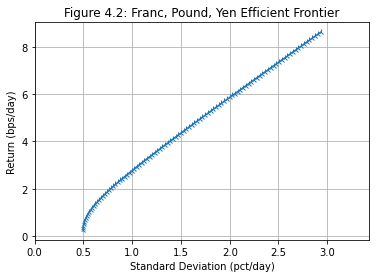

In [162]:
#Draw graph of simple efficient frontier
lambda1s=np.arange(0,1.01,.01)
xrisk=100*np.sqrt(lambdacoeff*lambda1s**2+1/uciu)   #Multiply * 100 for percent/day units
yreturn=10000*(lambdacoeff*lambda1s+constmu)        #Multiply * 10000 for bp units

plt.figure(1)
plt.plot(xrisk,yreturn,marker='2')
plt.title("Figure 4.2: Franc, Pound, Yen Efficient Frontier")
plt.xlabel("Standard Deviation (pct/day)")
plt.ylabel("Return (bps/day)")
plt.xlim(0,max(xrisk)+.5)
plt.grid()
plt.show();

In [164]:
# get 11 efficient portfolios from learning set 
def get_portfolios(vec1, vec2):
    lambdas = list(x /100 for x in range(0,11))
    portfolios = []
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    for value in lambdas:
        portfolios.append(value * vec1 + vec2)
    return portfolios
    

In [165]:
efficient_portfolios = get_portfolios(vec1, vec2)

In [166]:
def get_variance(portfolios, c):
    variance = []
    for portfolio in portfolios:
        variance.append(np.matmul(np.matmul(portfolio.T, c), portfolio))
    return variance

In [168]:
# get covariance matrix for holdout set using total rate matrix we pulled before
dates_2021 = [date for date in cdates if date[0:4] == "2021"]
count_2021 = len(dates_2021)
rates_2021 = ratematrix[len(ratematrix)-count_2021:]
lgdatesH,difflgsH=qf.levels_to_log_returns(dates_2021,rates_2021,multipliers)

d_H=np.array(difflgsH)
m_H=np.mean(d_H,axis=0)
c_H=np.cov(d_H.T)

In [170]:
# Get variances from learning and holdset of the 11 portfolios on efficient
# frontier in learning set and compare 
variance_learning = get_variance(efficient_portfolios, c)
variance_holdout = get_variance(efficient_portfolios, c_H)
df_display = pd.DataFrame()
df_display['learning'] = variance_learning
df_display['holdout'] = variance_holdout
df_display

,learning,holdout
0,0.000025,0.000009
1,0.000025,0.000009
2,0.000025,0.000009
3,0.000025,0.000009
4,0.000026,0.000009
5,0.000027,0.000009
6,0.000028,0.000009
7,0.000029,0.000009
8,0.000030,0.000010
9,0.000031,0.000010


Looking at the variances, we see that in the holdout set that the minimum variance is also at lambda = 0, and that variances only stay the same or increase as lambda increases, like they do in the learning set. 

We also see that the variances are smaller in the holdout set than the learning set, where approximately on average the learning set variances 3x larger than the holdout set variances. 